# Sparkify Project , Potential Churn User Prediction with PySpark


## Project Overview and problem (goal) statement
This is a sample project to identify 

The goal is to train a binary classifier to identify users (in both free and paid tier) who might the Sparkify music streaming service, based on the patterns obtained from their past activity and interaction with the service. 

The project used a tiny subset (128MB) to conduct data analyaia and develop the model, and the full dataset available (12GB) to train and validate model.

## Approach
This notebook is arranged based on the following approach:
1. Data exploration: to understand the data, find data distribution and boundaries, find data anormaly and etc.
2. Data wrangling: to clean data, derive data,visualize and summarize data
3. Feature engineering: to define and generate features and label to be used in the model training, create train and test data set.
4. Model training and evaluation: develop a few pilot models, define evaluation metrics for the model. Conduct initial evaluation for the model.
5. Model tuning and conclusion: conduct parametric search to find best hyperparameters, and conduct model evaluation with final conclusion. 


In [2]:
# import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# create a Spark session

from pyspark.sql import SparkSession

import pyspark.sql.functions as sf
from pyspark.sql.functions import sum as Fsum, min as Fmin, max as Fmax, when, col, count, first, countDistinct

import pyspark.sql.types as st
from pyspark.sql.types import DateType, IntegerType

from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler




# Data exploration
 1. understand the data 
 2. find data distribution and boundaries
 3. find data anormaly

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Initial Exploration") \
    .getOrCreate()

In [5]:
df_raw = spark.read.json('mini_sparkify_event_data.json')

In [6]:
# df_raw = spark.read.json("s3n://udacity-dsnd/sparkify/sparkify_event_data.json")

In [7]:
#check the columns for any invalid value
df_raw.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
missing = df_raw.select([sf.count(sf.when(sf.isnull(col), col)).alias(col) for col in df_raw.columns]).toPandas().T

missing.columns = ['null_count']

missing

,null_count
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


## Findings: 

The rows with null value for firstname does not any userId information. 
The are about 5% of the data.
It is better to remove it from the df.


Looks the logs with missing artist and orther information are the rows of actions other than plany music.
They are valuable for predicting user status.
Keep the data, but might be good idea to fill the data with 'n/a'

In [9]:
convert_ms_udf = sf.udf(lambda t: None if t is None else t//1000, st.LongType())

def clean_df(df_raw):
    """
    Takes in a raw events dataframe, makes a few extra columns and cleans it.
    concretely: 
    1.filter out rows without user information 
    2.fill the null values for song information for actions other than playing song
    3.change the timestamp unit to ms.
    4.create user register timestamp and current timestamp column with datetype of timestamp
    
    INPUT: (dataframe) raw dataframe
    
    OUTPU: (dataframe) dataframe with clean data, no null or empty data
    
    """
    df_raw =  df_raw.dropna(subset = ['gender'], how = 'any')
    df_raw = df_raw.fillna('n/a', subset=['artist','song'])
    df = df_raw.fillna(0, subset=['length'])
    
    
    # Clean time columns
    df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
    df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))

    return df

In [10]:
df = clean_df(df_raw)

In [11]:
#check the cleaned dataframe
df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---------+---------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|timestamp|registration_ts|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---------+---------------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|        0|              0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---------+---------------+



In [12]:
#get an overview of distince values in the dataset
distinct_all = df.agg(*(sf.countDistinct(c).alias(c) for c in df.columns))
distinct_all.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+---------+---------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|timestamp|registration_ts|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+---------+---------------+
| 17656|   2|      189|     2|         1311|     173| 14866|    2|     114|     2|  19|         225|     2312|58481|     3|269770|       56|   225|   269770|            225|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+---------+---------------+



In [13]:
df.select(['page']).distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
df.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [15]:
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [16]:
df.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [17]:
df.groupby('location').count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



In [18]:
df.where(df.page == 'Submit Downgrade').groupby(['auth','page']).count().show()

+---------+----------------+-----+
|     auth|            page|count|
+---------+----------------+-----+
|Logged In|Submit Downgrade|   63|
+---------+----------------+-----+



In [19]:
df.agg(sf.min('timestamp'), sf.max('timestamp'))

DataFrame[min(timestamp): timestamp, max(timestamp): timestamp]

# Data wrangling

### Define Churn

Using the `Cancellation Confirmation` events to create a column `is_churn` to use as the label for the model. The `Downgrade` events is not used sincei I found it is not directly correlated to churn user. (multiple downgrade action might not lead to confirmed cancallation.

### Data summary and visulization
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
#identify churn users and mark the dataframe
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df = df.withColumn("is_churn", sf.when(df.userId.isin(churn_users_list),1).otherwise(0))

In [21]:
df_pd = df.groupBy(['is_churn','gender']).agg(sf.count('userId').alias('user_counts')).orderBy(['is_churn','gender']).toPandas()
df_pd.head()

,is_churn,gender,user_counts
0,0,F,135410
1,0,M,97880
2,1,F,19168
3,1,M,25696


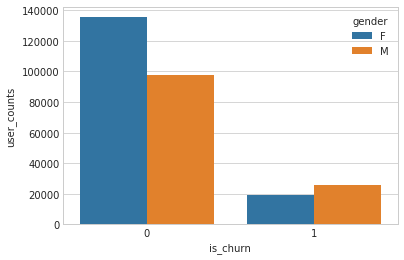

In [22]:
fig, ax = plt.subplots() 

ax = sns.barplot(x='is_churn', y='user_counts', hue='gender', data=df_pd)

# fig.show()

In [23]:
#Findings: 
#male churn at higher rate. 
#consider use gender as a feature

In [24]:
churn_count = df.filter(df.is_churn==1).count()
no_churn_count = df.filter(df.is_churn==0).count()

df_temp1 = df.filter(df.is_churn==1).filter(df.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df.filter(df.is_churn==0).filter(df.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()

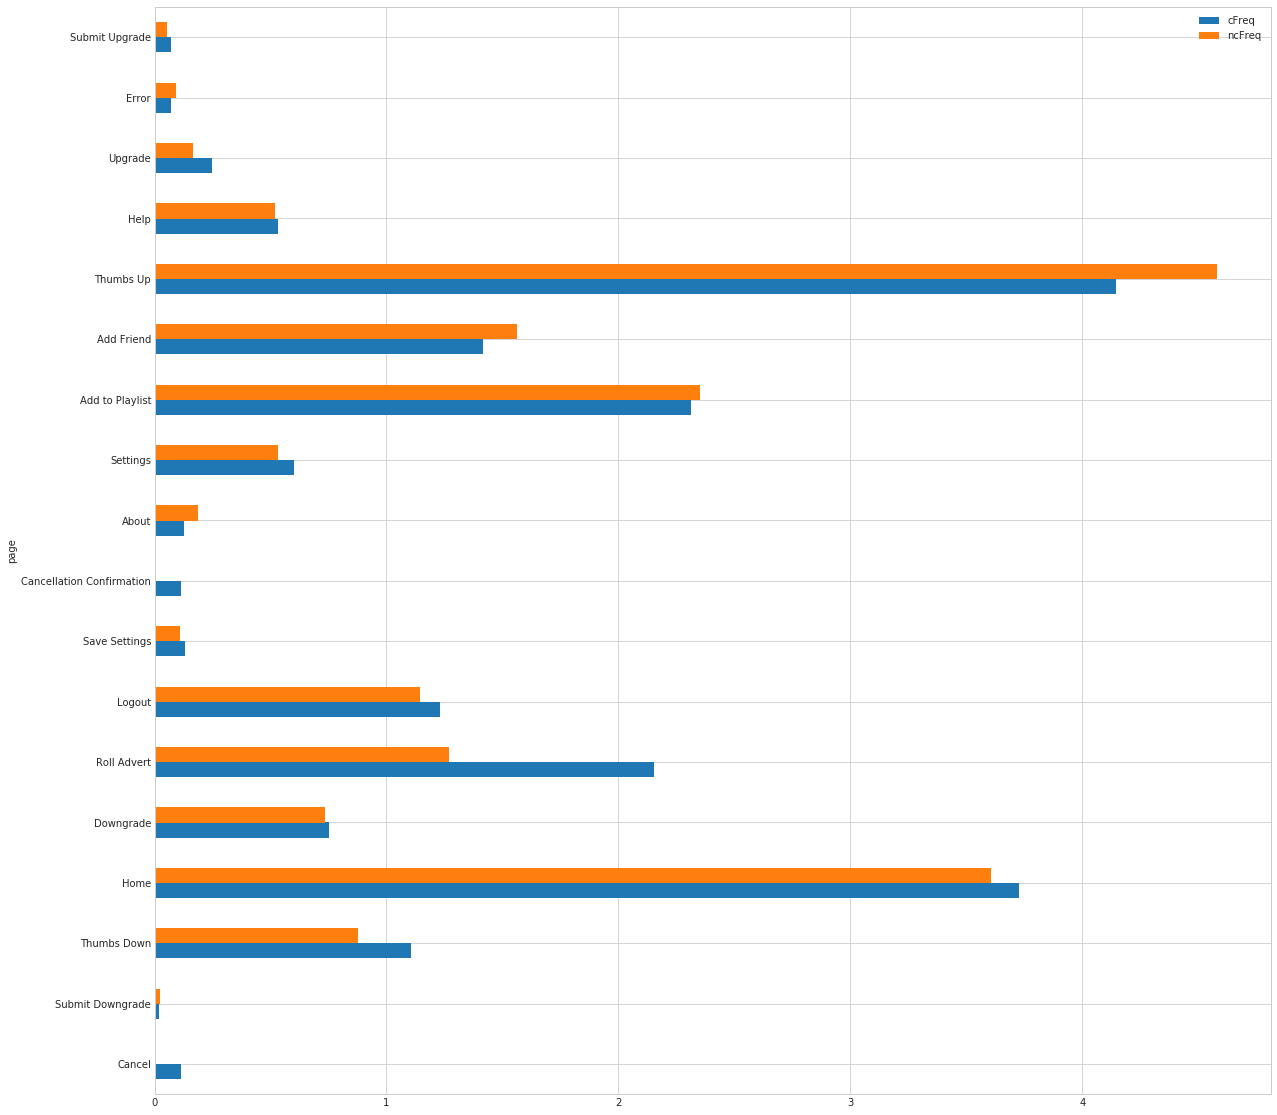

In [56]:
df_pd.plot.barh("page")

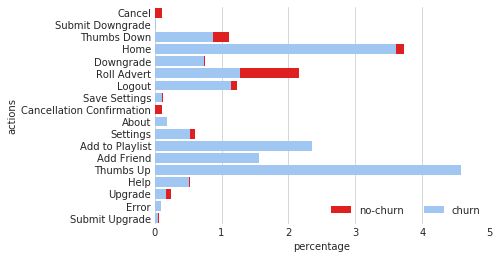

In [25]:
fig, ax = plt.subplots() 
width = 0.4

# sns.set_color_codes("muted")
ax = sns.barplot(x = 'cFreq', y = "page", data=df_pd,
            label="no-churn", color="r")

sns.set_color_codes("pastel")
ax = sns.barplot(x = 'ncFreq', y = "page", data=df_pd,
            label="churn", color="b" )

ax.legend(ncol=2, loc="lower right" )
ax.set(xlim=(0, 5), ylabel="actions",
       xlabel="percentage" )
sns.despine(left=True, bottom=True)

In [26]:
#Findings
# not much difference in user action distribution, except the Roll Advert

# Feature Engineering


## Some initial thoughts 
### what inforamtion indicates unhappy user?

* user interact with the app a lot or not
* user add friends or add song to the list (cumulative effort for future. increase user retention rate)
* user get visiting help page a lot (lost in interface, bad sign)
* user skip song a lot (impatient user, unhappy with the songs )
* user open app (login) a lot or very occasionally 
* user get a lot of error page
* user thumbs up/ down a lot in a given time frame
* very little activities per session


In [27]:
#get the earliest and latest timestamp of the dataset

extreme_ts = df.agg(sf.min('ts').alias('earliest'), sf.max('ts'))
earliest_ts = extreme_ts.take(1)[0][0]
latest_ts = extreme_ts.take(1)[0][1]

In [28]:
#define windows to facilitate aggregation

windowsession = Window.partitionBy('userId','sessionId').orderBy('ts')
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [29]:
df = df.withColumn("lastlogtime", sf.last(sf.col('ts')).over(windowuser))

#I think it is better to monitor from the last log time for non-churn users and cancellation confirmation ts (which is last log time as well) for churn users. 
df = df.withColumn("obsend", df.lastlogtime)

In [30]:
#consider user cancel is impulsive action based on recent experience, we only focus on the activities during the last 4 weeks. 

trend_est_days = 28
trend_est_hours = trend_est_days * 24
# In timestamp format
trend_est = trend_est_days * 24 * 60 * 60 * 1000

udf_ck_ts_in_range = sf.udf(lambda col1, col2 : 1 if (col1 < col2) and (col1+trend_est >= col2)  else 0, st.IntegerType())
df = df.withColumn('in_range', udf_ck_ts_in_range(sf.col('ts'), sf.col('obsend')))

In [31]:
df.groupby('in_range', 'is_churn').agg(sf.count('userId')).show()
#Findings: 
#seems that the time range is reasonable

+--------+--------+-------------+
|in_range|is_churn|count(userId)|
+--------+--------+-------------+
|       1|       0|       127382|
|       1|       1|        35528|
|       0|       0|       105908|
|       0|       1|         9336|
+--------+--------+-------------+



In [32]:
#focus on data within the taget time range
df_model = df.where(df.in_range == True)

In [33]:
# Aggregation by userId, some direct features
df_user = df_model.groupby('userId')\
.agg(
     first(col('is_churn')).alias('label'),
     # User-level features
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     Fmin(col('ts')).alias('obsbegin'),
     first(col('obsend')).alias('obsend'),
     # Aggregated activity statistics
    
     count(col('page')).alias('nact'), #indicating if user are actively engaging or not
     countDistinct(col('sessionId')).alias('nsession'),     #indicating if user are actively engaging or not
     Fsum(when(col('page') == "NextSong", 1).otherwise(0)).alias("nsong"),  #indicating if user are playing song or not
     Fsum(when(col('page') == "Thumbs Up", 1).otherwise(0)).alias("ntbup"),
     Fsum(when(col('page') == "Thumbs Down", 1).otherwise(0)).alias("ntbdown"),
     Fsum(when(col('page') == "Add Friend", 1).otherwise(0)).alias("nfriend"),
     Fsum(when(col('page') == "Add to Playlist", 1).otherwise(0)).alias("nplaylist"),     
     Fsum(when(col('page') == "Submit Downgrade", 1).otherwise(0)).alias("ndgrade"),
     Fsum(when(col('page') == "Submit Upgrade", 1).otherwise(0)).alias("nugrade"),
     Fsum(when(col('page') == "Home", 1).otherwise(0)).alias("nhome"),
     Fsum(when(col('page') == "Roll Advert", 1).otherwise(0)).alias("nadvert"),
     Fsum(when(col('page') == "Help", 1).otherwise(0)).alias("nhelp"),
     Fsum(when(col('page') == "Error", 1).otherwise(0)).alias("nerror")
)

In [34]:
# Calculation of the derived features

#act_per_session: #indicating if user are using the app or just getting in and out (test the water, impatient)
#indicating if user are playing songs or other actions (indicating potential churn)
#indicating if user like the songs or not
#indicating if user dislike the songs or not
#indicating if user are engaging with friend, given the time they spent within sparkify
#indicating if user are saving the songs for later usage, given the time they spent within sparkify
#use this metric since large difference were found between churn and non-churn users
#if user are getting a lot of errors for the time they engaged.
df_user = df_user.withColumn('act_per_session', col('nact') / col('nsession'))\
.withColumn('song_per_act', col('nsong') / col('nact'))\
.withColumn('ntbup_per_song', col('ntbup') / col('nsong'))\
.withColumn('ntbdown_per_song', col('ntbdown') / col('nsong'))\
.withColumn('nfriend_per_act', col('nfriend') / col('nact'))\
.withColumn('nplaylist_per_act', col('nplaylist') / col('nact'))\
.withColumn('nadvert_per_act', col('nadvert') / col('nact'))\
.withColumn('nerror_per_act', col('nerror') / col('nact'))\
.withColumn('obsrange', (col('obsend') - col('obsbegin'))/(24 * 60 * 60 * 1000))

In [35]:
df_user.show(1)

+------+-----+------+-------------+-------------+----+--------+-----+-----+-------+-------+---------+-------+-------+-----+-------+-----+------+---------------+------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------+------------------+
|userId|label|gender|     obsbegin|       obsend|nact|nsession|nsong|ntbup|ntbdown|nfriend|nplaylist|ndgrade|nugrade|nhome|nadvert|nhelp|nerror|act_per_session|      song_per_act|     ntbup_per_song|    ntbdown_per_song|     nfriend_per_act|   nplaylist_per_act|   nadvert_per_act|nerror_per_act|          obsrange|
+------+-----+------+-------------+-------------+----+--------+-----+-----+-------+-------+---------+-------+-------+-----+-------+-----+------+---------------+------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------+------------------+
|100010|    0|     1|1541411290000|1542823952000| 21

In [36]:
df_user = df_user.withColumn('act_per_day', col('nact') / col('obsrange'))\
.withColumn('session_per_day', col('nsession') / col('obsrange'))\
.withColumn('song_per_day', col('nsong') / col('obsrange'))

In [37]:
df_user = df_user.withColumn('act_per_session', col('nact') / col('nsession'))\
.withColumn('song_per_act', col('nsong') / col('nact'))\
.withColumn('ntbup_per_song', col('ntbup') / col('nsong'))\
.withColumn('ntbdown_per_song', col('ntbdown') / col('nsong'))\
.withColumn('nfriend_per_act', col('nfriend') / col('nact'))\
.withColumn('nplaylist_per_act', col('nplaylist') / col('nact'))\
.withColumn('nadvert_per_act', col('nadvert') / col('nact'))\
.withColumn('nerror_per_act', col('nerror') / col('nact'))\
.withColumn('obsrange', col('obsend') - col('obsbegin'))

In [38]:
#Some more derived features

from pyspark.sql.functions import max as Fmax, avg
# Calculation of user's average number of items per session
session_avgnitems = df.groupby(['userId', 'sessionId'])\
.agg(Fmax(col('itemInSession')).alias('nitems'))\
.groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))

from pyspark.sql.functions import min as Fmin
# Calculation of user's average session length
session_avglength = df.groupby(['userId', 'sessionId'])\
.agg(Fmin(col('ts')).alias('startsession'), Fmax(col('ts')).alias('endsession'))\
.groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessionlength'))


In [39]:
# Adding the extra features to the df_user dataset with all other engineered features
df_user = df_user\
.join(session_avgnitems, on = 'userId')\
.join(session_avglength, on = 'userId')

In [40]:
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- obsbegin: long (nullable = true)
 |-- obsend: long (nullable = true)
 |-- nact: long (nullable = false)
 |-- nsession: long (nullable = false)
 |-- nsong: long (nullable = true)
 |-- ntbup: long (nullable = true)
 |-- ntbdown: long (nullable = true)
 |-- nfriend: long (nullable = true)
 |-- nplaylist: long (nullable = true)
 |-- ndgrade: long (nullable = true)
 |-- nugrade: long (nullable = true)
 |-- nhome: long (nullable = true)
 |-- nadvert: long (nullable = true)
 |-- nhelp: long (nullable = true)
 |-- nerror: long (nullable = true)
 |-- act_per_session: double (nullable = true)
 |-- song_per_act: double (nullable = true)
 |-- ntbup_per_song: double (nullable = true)
 |-- ntbdown_per_song: double (nullable = true)
 |-- nfriend_per_act: double (nullable = true)
 |-- nplaylist_per_act: double (nullable = true)
 |-- nadvert_per_act: double (nullable = true)
 |--

In [41]:
print((df_user.count(), len(df_user.columns)))

(225, 32)


In [42]:
df_user.persist()

DataFrame[userId: string, label: int, gender: int, obsbegin: bigint, obsend: bigint, nact: bigint, nsession: bigint, nsong: bigint, ntbup: bigint, ntbdown: bigint, nfriend: bigint, nplaylist: bigint, ndgrade: bigint, nugrade: bigint, nhome: bigint, nadvert: bigint, nhelp: bigint, nerror: bigint, act_per_session: double, song_per_act: double, ntbup_per_song: double, ntbdown_per_song: double, nfriend_per_act: double, nplaylist_per_act: double, nadvert_per_act: double, nerror_per_act: double, obsrange: bigint, act_per_day: double, session_per_day: double, song_per_day: double, avgsessionitems: double, avgsessionlength: double]

In [43]:
df_user_pd = df_user.toPandas()

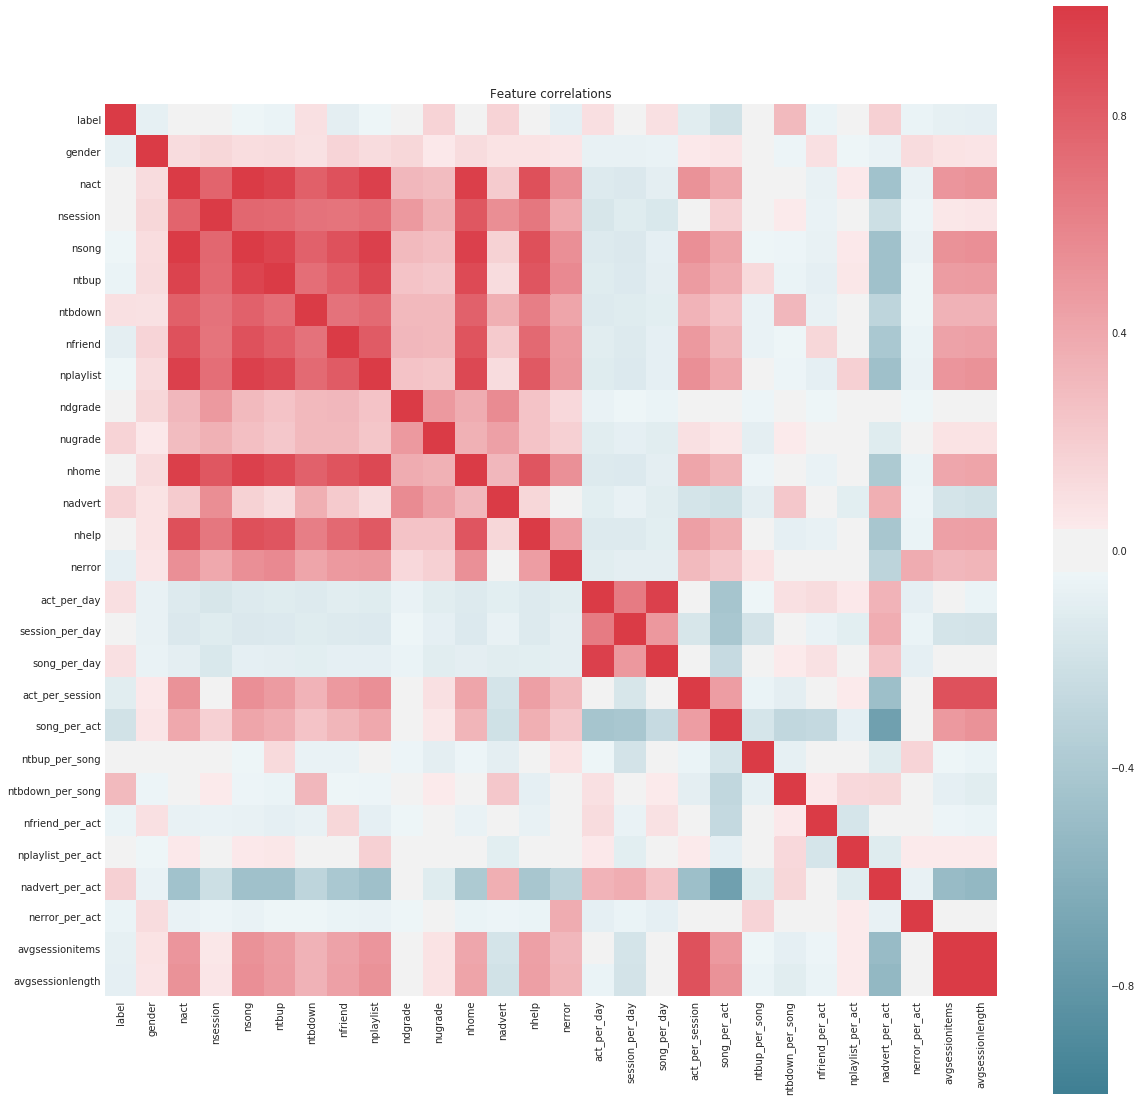

In [44]:
cormat = df_user_pd[
['label',
 'gender',
 'nact',
 'nsession',
 'nsong',
 'ntbup',
 'ntbdown',
 'nfriend',
 'nplaylist',
 'ndgrade',
 'nugrade',
 'nhome',
 'nadvert',
 'nhelp',
 'nerror',
 'act_per_day',
 'session_per_day',
 'song_per_day',
 'act_per_session',
 'song_per_act',
 'ntbup_per_song',
 'ntbdown_per_song',
 'nfriend_per_act',
 'nplaylist_per_act',
 'nadvert_per_act',
 'nerror_per_act',
 'avgsessionitems',
 'avgsessionlength']
].corr()

# %matplotlib inline

# Plot correlations
plt.rcParams['figure.figsize'] = (20,20)
# plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.heatmap(cormat, cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, vmin = -1, vmax = 1)
plt.title('Feature correlations')
plt.savefig('correlations.png')
plt.show()

In [45]:
#Findings 
#the label is correlated with a few factors. We will check these factor importance later.


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [47]:
#generate train-test data set

train_plus_val, test = df_user.randomSplit([0.8, 0.2], seed = 9) 
ntotal = df_user.count()
ntrainval = train_plus_val.count()
ntest = test.count()

print('Original dataset: {} rows. Training and validation: {} rows. Testing set: {} rows'.format(ntotal,ntrainval,ntest))

Original dataset: 225 rows. Training and validation: 179 rows. Testing set: 46 rows


In [48]:
numeric_columns = [
 'nact',
 'nsession',
 'nsong',
 'ntbup',
 'ntbdown',
 'nfriend',
 'nplaylist',
 'ndgrade',
 'nugrade',
 'nhome',
 'nadvert',
 'nhelp',
 'nerror',
 'act_per_day',
 'session_per_day',
 'song_per_day',
 'song_per_act',
 'ntbup_per_song',
 'ntbdown_per_song',
 'nfriend_per_act',
 'nplaylist_per_act',
 'nadvert_per_act',
 'nerror_per_act',
 'avgsessionitems',
 'avgsessionlength']

In [49]:
# Combining multiple numerical features using VectorAssembler
numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

# Standardizing numerical features
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)

# Adding the two binary features
binary_columns = [ 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")


In [50]:
# Gradient-boosted tree classifier with pipeline
gb = GBTClassifier()
pipeline_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, gb])

In [51]:
# Parameter combinations
paramGrid_gb = ParamGridBuilder()\
.addGrid(gb.maxDepth, [3, 5])\
.addGrid(gb.maxIter, [20, 100])\
.build()


# Grid search with cross validation
crossval_gb = CrossValidator(estimator = pipeline_gb,
                          estimatorParamMaps = paramGrid_gb,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

In [52]:
# Perform the grid search by fitting the grid search object
import time
start = time.time()

crossvalmodel_gb = crossval_gb.fit(train_plus_val)
end = time.time()
print('Time spent for grid search: {} seconds'.format(round(end-start)))

Time spent for grid search: 3184 seconds


In [53]:
# Store grid search results in a dataframe
scores = crossvalmodel_gb.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,score
0,3,0.632219
1,5,0.628259


In [1]:
# bestPipeline = crossvalmodel_gb.bestModel
# bestLRModel = bestPipeline.stages[3]
# bestParams = bestLRModel.extractParamMap()

NameError: name 'crossvalmodel_gb' is not defined

#Findings 
The best parameters are: 

In [43]:
import time

# Retrain the classifier with the best performing parameters
best_gb =  GBTClassifier(maxDepth = 5, maxIter = 30)
pipeline_best_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_gb])

start = time.time()
model_gb = pipeline_best_gb.fit(train_plus_val)
end = time.time()
print('Time spent for training: {} seconds'.format(round(end-start)))

Time spent for training: 2461 seconds


In [44]:
# Display feature importances
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
15,session_per_day,0.097932
17,song_per_act,0.080686
19,ntbdown_per_song,0.072722
7,nplaylist,0.064782
18,ntbup_per_song,0.059976
24,avgsessionitems,0.059704
11,nadvert,0.057487
4,ntbup,0.055122
21,nplaylist_per_act,0.051047
6,nfriend,0.045145


# Results

# Evaluate the model

In [46]:
# Obtain predictions on the test set
results_gb = model_gb.transform(test)
results_gb.select(['userId','label','prediction','probability']).show(5)

+------+-----+----------+--------------------+
|userId|label|prediction|         probability|
+------+-----+----------+--------------------+
|   138|    0|       0.0|[0.92471522393293...|
|   112|    0|       0.0|[0.66456232371933...|
|200010|    0|       0.0|[0.89700421682992...|
|    34|    0|       0.0|[0.96678529538211...|
|     8|    0|       0.0|[0.98856881947728...|
+------+-----+----------+--------------------+
only showing top 5 rows



In [47]:
# AUC score on the test set
auc_evaluator = BinaryClassificationEvaluator()
auc_gb = auc_evaluator.evaluate(results_gb)
print('Logistic regression AUC score: {}'.format(auc_gb))

Logistic regression AUC score: 0.6620046620046619


In [ ]:
#Logistic regression AUC score: 0.6666666666666666


In [49]:
#Custom F1 score evaluator that we can use instead of BinaryClassificationEvaluator() in grid search
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon to prevent division by zero
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

In [50]:
# F1 score on the test set
f1_evaluator = F1score()
f1score_gb = f1_evaluator._evaluate(results_gb)
print('Logistic regression F1 score: {}'.format(f1score_gb))

Logistic regression F1 score: 0.3478208696347817


In [ ]:
#Logistic regression F1 score: 0.5454492149190361


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# Conclusion

## Reflection

This project is a demostration of my skills in pyspark as well as other modules. 
The success of the machine learning model, is largely depending on good insight of the data, good job in data cleaning, especially feature engineering. 

Due to limit of time and effort, this project did not get further in model tuning, model comparison and model ensemble. But it is more of research and problem solving than demostrate programming skills and general knowledge of entire process. Therefore, it is not elaborated here. 


## Improvement

The features used in this project is data gathered over one period of time. It might be useful to create features based on the user behavior change over time. Because different kind of user might have different usage pattern, some heavy user might have exactly the same user behavior as light user, while quite lower actions per day compare to previous time range. A feature based on the changes in statistical data summary would be helpful in identifying such user.